<a href="https://colab.research.google.com/github/alice4space/CohortProject_2021/blob/week1/Week1_Trapped_Ions/CDL_project_week1_team2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Initialisation**

### installs

In [18]:
from IPython.display import clear_output

In [19]:
!pip install qiskit
clear_output(wait=True)

### imports

In [20]:
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.providers.aer import AerSimulator

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [22]:
from IPython.display import HTML

### functions

In [23]:
def plot_dots(values):
  xs = np.array(range(len(values)))
  ys = 0*xs
  ss = values
  plt.scatter(xs,ys,s=ss,c="red")

In [24]:
#rgate layer
def addRgate(circuit,thetas,phis):
  N = circuit.num_qubits
  for i in range(N):
    circuit.u(thetas[i], phis[i], 0,i)
  return circuit

In [25]:
#mgate layer
def addMgate(circuit,idx_first,psis):
  N = circuit.num_qubits
  for i in range(idx_first,(N-1),2):
    circuit.rxx(psis[i],i,i+1)
  return circuit

In [26]:
def random_circuit(numQbits, depth, thetas = None, phis = None, psis = None):
  circuit = QuantumCircuit(numQbits)
  if thetas is None:
    thetas= np.random.rand(numQbits,depth)*2*np.pi
  if phis is None:
    phis= np.random.rand(numQbits,depth)*2*np.pi
  if psis is None:
    psis= np.random.rand(numQbits,depth)*2*np.pi
  
  for d in range(depth):
    circuit = addRgate(circuit,thetas[:,d],phis[:,d])
    circuit = addMgate(circuit,d % 2 + 1,psis[:,d])
  circuit.measure_all()
  return circuit

In [27]:
def generate_speckle(circuit,plotSpeckle=True,shots=1024):
  # Select the AerSimulator from the Aer provider
  simulator = AerSimulator(method='matrix_product_state')

  # Execute the quantum circuit
  tcirc = transpile(circuit, simulator)
  result = simulator.run(tcirc,shots=shots).result()
  # Obtain the counts for each measured state
  counts=result.get_counts()

  values = counts_to_ordered(counts)
  
  #plot speckle
  if plotSpeckle ==True:
    plot_dots(values)

  return values

In [28]:
def counts_to_ordered(counts):
  keys = list(counts.keys())
  values = list(counts.values())
  numQbits= len(keys[0])
  A = np.zeros(2**numQbits)
  for k,v in zip(keys,values):
    A[int(k,2)]=v
  return A

In [29]:
def circuit_bitflip(circuit):
  N = circuit.num_qubits
  num_gates = len(circuit.data)
  qbit_noise = random.choice(range(N))
  position_noise = random.choice(range(num_gates))
  circuit.x(qbit_noise)
  xgate = circuit.data[-1]
  del circuit.data[-1]
  circuit.data.insert(position_noise,xgate)
  return circuit

In [30]:
def ideal_distribution(numQbit):
  N = 2**numQbit
  logps = np.arange(0,3,0.1)
  ps = 10**-logps
  A = 1-np.exp(-N*ps)
  plt.semilogx(ps,A,'k',label='ideal')
  return A

In [31]:
def p_distrib(numQbit,depth,numSample = 32,shots=32768,plotResults = True):
  
  #simulate random circuits
  values = np.zeros((2**numQbit,numSample))
  for s in range(numSample):
    circuit = random_circuit(numQbit,depth)
    values[:,s] = generate_speckle(circuit,plotSpeckle=False,shots=shots);
  
  #cum distribution
  values = values/shots
  values_flat_sort = np.sort(values.flatten())

  #plot results
  if plotResults == True:
    label = 'd = ' + str(depth) + ', n = ' + str(numQbit)
    plot_cdf(values_flat_sort, label = label)

  return values

In [32]:
def plot_cdf(values_sorted, label= ''):
    n_samples = values_sorted.size
    ys = np.arange(n_samples)/n_samples
    xs = values_sorted
    plt.semilogx(xs[xs!=0],ys[xs!=0],label=label)
    plt.xlim([10**-3,1])
    plt.grid()

## **Introduction**

This week, we will create and simulate a simple circuit for an ion trap quantum computer by applying 1-qubit and 2-qubit gates to a quantum state. In practice qubits are stored in the spins of the individual ions while they are suspended in the vacuum via the use of electromagnetic fields. Confining the ions in two dimensions they form a line. Initializing the state of the system and
measurement are both implemented using lasers with a very high efficiency. 1-qubit and 2-qubit gates are implemented via laser-driven stimulated Raman transitions.This gives rise to the single-qubit physical level gates R and two-qubit M interactions described by following unitary evolution operator:

$$
R(\theta,\phi) =
\begin{pmatrix}
 \cos \frac{\theta}{2} & -\mathrm{i}\mathrm{e}^{-\mathrm{i}\phi}\sin \frac{\theta}{2} \\
 -\mathrm{i}\mathrm{e}^{\mathrm{i}\phi}\sin \frac{\theta}{2} & \cos \frac{\theta}{2}\\
\end{pmatrix}.
$$

Both $\theta$ and $\phi$ can be controlled by changing the duration and phase of the Raman beatnote that drives the Rabi oscillation of the qubit [1]. The physical two-level qubit gate which implements the well-known Molmer-Sorensen gate [2] is defined as

$$
M(\theta,\phi) =
\begin{pmatrix}
 \cos \Theta &0&0& -\mathrm{i}\sin \Theta \\
 0 &\cos \Theta&-\mathrm{i}\sin \Theta& 0 \\
 0 &-\mathrm{i}\sin \Theta&\cos \Theta& 0 \\
 -\mathrm{i}\sin \Theta &0&0& \cos \Theta\\
\end{pmatrix},
$$
where $\Theta$ depen on the pair of ions that the gate is applied to and it can be set to an arbitrary real number between 0 and $\pi/2$ by varying the laser power applied to the ions.

We continue in task 2 by simulating the perturnbations in the circuit parameters by inserting errors in the quantum circuit. This can be modeled by adding bit-flip ($\sigma_x$) to the circuit. We also observe that such chaos that arises in individual measurements
of random circuits can be tamed by averaging over several measurements.

Before proceeding to the tasks below, we also need to give an overview of random Matrix Product State (MPS), which represents a quantum
state $\left|\Psi\right\rangle$. We need this for the bonus part of task 1. 

For the past twenty years, MPS has been widely used in solid state physics to approximate the ground state of one-dimensional spin chains. MPS is a class of Tensor Network States (TNS) [3] which is a class of many-body wavefunctions of complexity, fixed by a parameter known as bond dimension (virtual dimension). The bond dimension is the dimension of the truncated MPS. For more details please refer to [this page](https://tensornetwork.org/mps/).

Relation between the bond dimension and the entanglement entropy is given in details in [4](https://arxiv.org/pdf/1308.3318.pdf), [5](https://arxiv.org/pdf/0705.0292.pdf), and [6](https://arxiv.org/pdf/2008.11764.pdf).









## **Task 1**

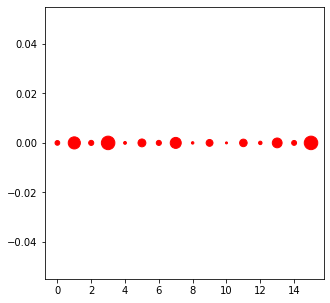

In [40]:
plt.figure(figsize=(5, 5))
circuit = random_circuit(4,7)
generate_speckle(circuit);

**Bonus**

The entanglement entropy $S$ of any region in a matrix product state of bond dimension d is bounded by $S≤2*log[d]$. Therefore, as the circuit becomes deeper, the bond dimension (and thus the memory and time of the computation) will grow exponentially so will the entanglement entropy [4](https://arxiv.org/pdf/0705.0292.pdf). For any subset A of consecutive tensors $S(\rho_A)=\mathrm{O}(log[d])$$ for a matrix product state, so the entanglement entropy is bounded from above by a constant in n (number of tensors). That is to say, MPS satisfy an area law. The behaviour of the entanglement scaling is therefore the same for matrix product states.

## **Task 2**

In this task we choose a random circuit and run it several times, each time adding a bit-flip error at random location in the circuit. Collection of plots below shows the difference in the resulting speckle patterns.

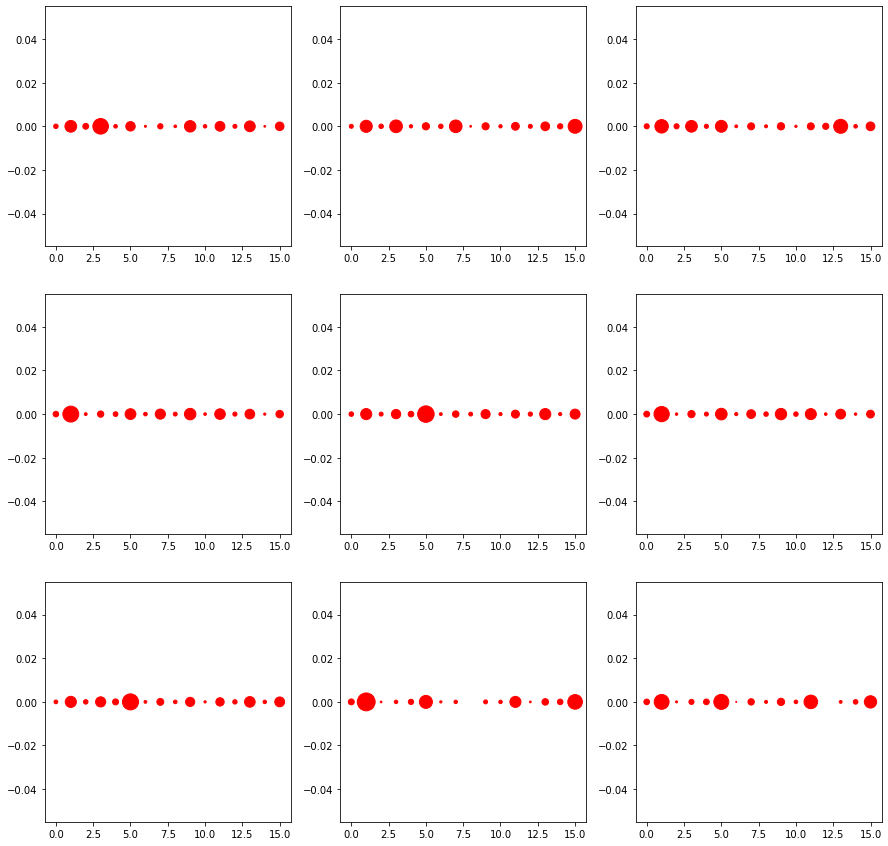

In [41]:
plt.figure(figsize=(15, 15))
k=1
for i in range(3):
  for j in range(3):
    plt.subplot(3,3,k)
    k+=1
    generate_speckle(circuit_bitflip(circuit));


## **Task 3**

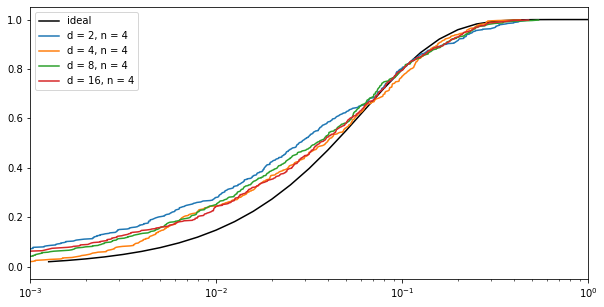

In [42]:
numQbit = 4
# logDepths = np.arange(1,10,4)
logDepths = np.arange(1,5)
depths = 2**logDepths

plt.figure(figsize=(10, 5))
ideal_distribution(numQbit);
for depth in depths:
  p_distrib(numQbit,depth,numSample=32)

plt.legend(loc='best');

## **Task 4**

### on going - not finalised

In [43]:
numQbit = 8
depth = 32
dPsis = np.arange(0,1,0.1)*np.pi
psis= np.random.rand(numQbit,depth)*2*np.pi

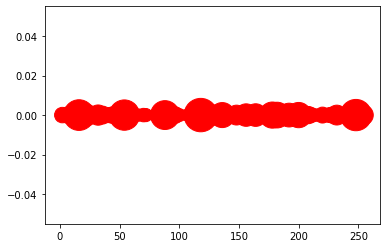

In [44]:
circuit = random_circuit(numQbit,depth,psis)
shots = 32768
values = generate_speckle(circuit_bitflip(circuit),shots=shots);
values = values/shots

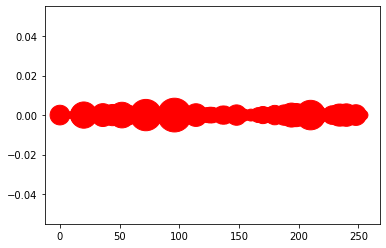

In [45]:
circuit_error = random_circuit(numQbit,depth,psis+0.5)
values = generate_speckle(circuit_bitflip(circuit_error),shots=shots);
values = values/shots

## **Business Application**

**Objective: devise a potential business that could be built around sampling-based quantum computing with random circuits in the NISQ era.**

## Step 1: Explain the technical problem you solved in this exercise

Computers are deterministic systems, meaning that when randomness is required, they are only capable of appearing superficially random. Classical computers rely on pseudo-random number generators and seeds usually based on system time to produce random distributions in a predictable fashion based on a formula.

Prior to the development of quantum physics it was thought that physical systems all had determinate states that were all measureable. The property of quantum indeterminacy suggests that quantum systems have truly random behavior that is not a result of measurement or disturbance errors. This randomness can be exploited for the purpose of random number generation.

## Step 2: Explain or provide examples of the types of real-world problems this solution can solve

In the past, devious mathematicians have been able to "game" lottery and casino systems through reverse-engineering (or stealing) the equations that are used to simulate randomness in the generation of values in these games. Due to this, the numbers generated by these deterministic algorithms are not truly random, and only appear to be. The problem with these systems is that it is difficult to provide truly random 

## Step 3: Identify at least one potential customer for this solution - ie: a business who has this problem and would consider paying to have this problem solved

Casino and lottery operators are the most logical applications. In order to accelerate adoption, a certification body could be created that provides "certified randomness," akin to ISO. This would likely allow for casinos and lottery companies to market their innovative solutions while also providing more trust that their systems aren't being taken advantage of by bad actors and provide trust and fairness to participants.

## Step 4: Prepare a 90 second video explaining the value proposition of your innovation to this potential customer in non-technical language


In [17]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/GapYtNXQENI" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Other notes/ideas to be potentially incorporated to make the business application more exciting/interesting:

Differential privacy is a system for publicly sharing information about a dataset by describing the patterns of groups within the dataset while withholding information about individuals within that dataset. The goal is to provide confidentiality across any specific individual, while still providing explorable statistical insights across subsets.

The Church-Turing thesis hypothesizes that any classical system can be simulated by a classical computer. Therefore using a classical system to generate randomness means that a classical computer could theoretically simulate it and therefore compute the random number generated.

A PRG doesn’t actually have enough entropy to generate truly random values, and therefore should not be used to simulate randomness.

Even if a PRG is broken in the future, forward-secrecy is maintained by a quantum computer. Even if the seed is public, the random bits can be private. Freshness property: random bits weren’t known to anyone before.

Measurements in QM are normally destructive. If you measure your state in the basis, where the outcome of the measurement is in one of the basis vectors, you can keep using that state over and over again: gentle measurement.

Given a quantum measurement M on n registers, we call M alpha-gentle if for every product state, and every possible outcome y of M. Example: Measuring the total Hamming weight of n unentangled qubits could be highly destructive. But measuring the Hamming weight plus noise of order sqrt(n) is far less destructive. (Protecting privacy rights of quantum states).

Measure the total Hamming weight of n unentangled qubits plus a noise term.

M is alpha-gentle -> M is O(alpha)-DP
M is epsilon-DP, and consists of a classical algorithm applied to the results of separate measurements on each register -> M can be implemented in a way that’s O(epsilon sqrt(n))-gentle.

Dataset, you want to look at it without damaging it too much.

Shadow Tomography: new measurement procedure for quantum states in d-dimensions. A list of two-outcome measurements, I can learn the approximate probabilities, that each of these measurements accepts my state, using a number of copies of rho that grow polylog(d). I want to know it’s behaviour of on N-circuits with N^2 gates, I can do that with only polynomially-many copies.

**Business application: using random noise for gentle measurements for DP: Data leaks are everywhere, and this is completely unacceptable for the quickly growing troves of health and genomics data.**
